# Training a machine learning model with automatic differentiation

In this tutorial we will: 

* implement a toy version of a typical machine learning setup,
* understand how automatic differentiation allows us to compute gradients of the machine learning model, and
* use automatic differentiation to train the model.

First some imports...

In [1]:
import pennylane as qml
from pennylane import numpy as np # This will import a special, "differentiable" version of numpy.

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

## 1. The three basic ingredients

A machine learning problem usually consists of *data*, a *model (family)* and a *cost function*: 

<br />
<img src="figures/data-model-cost.png" width="500">
<br />

*Training* selects the best model from the family by minimising the cost on a training set of data samples. If we design the optimisation problem well, the trained model will also have a low cost on new sets of data samples that have not been used in training. This means that the model *generalises* well. 

We will now create examples for each ingredient.

### Data

Let us create a two-dimensional toy dataset.

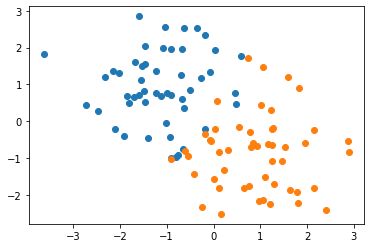

In [2]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))


plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

### Model family

Next, we construct a linear model.

In [3]:
print(X0[0])

[-0.50328585  0.8617357 ]


In [4]:
def model(x, w):
    return np.dot(x, w)

Let's try it out.

In [5]:
w = np.array([-0.5, -0.2])

model(X0[0], w)

0.07929578372862056

We can plot the decision boundary, or the boundary in data space where the model flips from a negative to a positive prediction

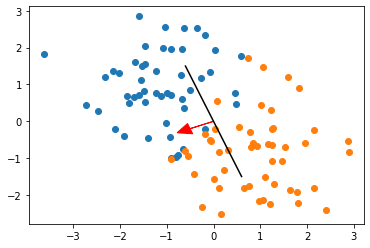

In [6]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

### Cost function

How good is the model on a single input-output training pair?

In [7]:
def loss(a, b):
    return (a - b)**2

What is the average loss on a data set of multiple pairs?

In [8]:
def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model(x, w)
        c += loss(prediction, y)
    return c/len(data)

In [9]:
w = np.array([1.3, -0.4])
average_loss(w, data)

1.8504767821580002

## 2. Automatic computation of  gradients

Because we imported PennyLane's numpy version, we can now compute gradients of the average loss with respect to the weights!

In [10]:
gradient_fn = qml.grad(average_loss, argnum=0)
gradient_fn(w, data)

array([ 3.29902953, -1.94918243])

We can use gradients to guess better candidates for parameters.

In [11]:
w_new = w - 0.05*gradient_fn(w, data)

In [12]:
average_loss(w_new, data)

1.2102626825705949

This works because the gradient always points towards the steepest ascent in the cost landscape.

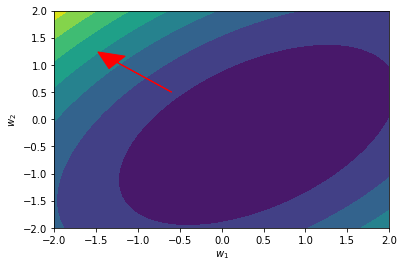

In [13]:
# compute the gradient at some point in parameter space
some_w = np.array([-0.6, 0.5])
g = 0.01*gradient_fn(some_w, data)

# make a contourplot of the cost
w1s = np.linspace(-2, 2)
w2s = np.linspace(-2, 2)
cost_grid = []
for w1 in w1s:
    for w2 in w2s:
        w = np.array([w1, w2])
        cost_grid.append(average_loss(w, data))
cost_grid = np.array(cost_grid).reshape((50, 50))
plt.contourf(w1s, w2s, cost_grid.T)

plt.arrow(some_w[0], some_w[1], some_w[0] + g[0], some_w[1] + g[1], 
          head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

## 3. Training with gradient descent

Putting it all together, we can train the linear model.

In [14]:
w_init = np.random.random(size=(2,))
w = np.array(w_init)

history = []
for i in range(15):
    w_new = w - 0.05*gradient_fn(w, data)
    print(average_loss(w_new, data))
    history.append(w_new)
    w = w_new

1.3500100407100541
1.1021852209348377
0.9290184060813584
0.8027576735134763
0.7073372523673335
0.6331673539752455
0.5743007976098509
0.5268826928791955
0.488294380852497
0.45667438524266574
0.4306452071742513
0.4091534224361
0.3913728909446769
0.3766437270037941
0.3644320177904416


We can easily visualise the path that gradient descent took in parameter space.

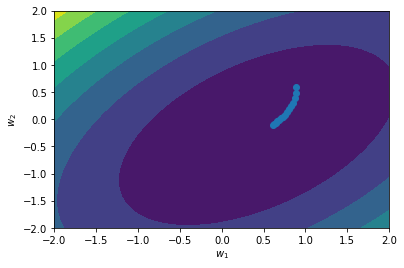

In [15]:
plt.contourf(w1s, w2s, cost_grid.T)
history = np.array(history)
plt.plot(history[:, 0], history[:, 1], "-o")
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

Training didn't fully converge yet, but the decision boundary is already better.

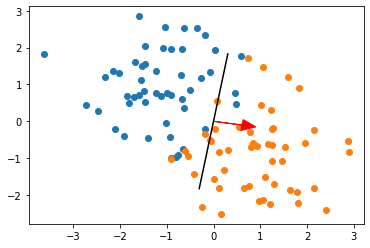

In [16]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

# TASKS 



1. Add a constant scalar bias term $b \in \mathbb{R}$ to the model,

    $$ f(x, w) = \langle w, x \rangle + b, $$

   and train both $w$ and $b$ at the same time.
   

2. Change the model to a neural network with a single hidden layer.

    $$ f(x, w, W) = \langle w, \varphi(Wx) \rangle,$$

   where $W$ is a weight matrix of suitable dimension and $\varphi$ a hand-coded nonlinar activation function. 
   
   Tipp: You can use the vector-valued sigmoid function 
   
   ```
   def sigmoid(z):
        return 1/(1 + np.exp(-x))
   ```
   

3. Code up the above example using PyTorch.

In [17]:
def model_with_bias(x, w, b):
    return np.dot(x, w) + b

def loss(a, b):
    return (a - b)**2

def average_loss_bias(w, b, data):
    c = 0
    for x, y in data:
        prediction = model_with_bias(x, w, b)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn = qml.grad(average_loss_bias, argnum=[0,1])

In [18]:
w_init = np.random.random(size=(2,))
w = np.array(w_init)
b_init = np.random.random(size=(1,))
b = np.array(b_init)

history = []
for i in range(60):
    w_new = w - 0.05*gradient_fn(w, b, data)[0]
    b_new = b - 0.05*gradient_fn(w, b, data)[1]
    print(average_loss_bias(w_new, b_new, data))
    history.append((w_new, b_new))
    w = w_new
    b = b_new

[1.32203557]
[1.03350539]
[0.8481652]
[0.72324144]
[0.63494931]
[0.56983]
[0.52008014]
[0.48102702]
[0.44975801]
[0.42437197]
[0.40356646]
[0.38640702]
[0.37219563]
[0.36039367]
[0.35057522]
[0.34239749]
[0.33558119]
[0.32989691]
[0.32515513]
[0.32119874]
[0.31789721]
[0.31514188]
[0.31284225]
[0.31092285]
[0.30932078]
[0.30798353]
[0.30686731]
[0.30593557]
[0.30515781]
[0.30450857]
[0.30396662]
[0.30351422]
[0.30313656]
[0.30282131]
[0.30255813]
[0.30233844]
[0.30215504]
[0.30200194]
[0.30187412]
[0.30176742]
[0.30167835]
[0.30160399]
[0.30154191]
[0.30149008]
[0.30144681]
[0.30141069]
[0.30138054]
[0.30135536]
[0.30133434]
[0.3013168]
[0.30130215]
[0.30128992]
[0.30127971]
[0.30127118]
[0.30126406]
[0.30125812]
[0.30125316]
[0.30124902]
[0.30124556]
[0.30124267]


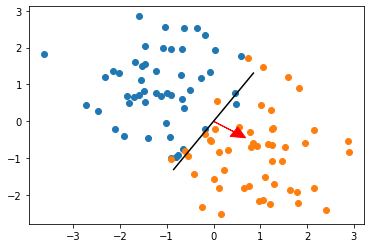

In [19]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

In [20]:
def sigmoid(z):
     return 1/(1 + np.exp(-z))

def model_with_nn_layer(x, W, w):
    fc1 = np.dot(x, W)
    fc1_post_activation = sigmoid(fc1)
    return np.dot(fc1_post_activation, w)

def loss(a, b):
    return (a - b)**2

def average_loss_nn(W, w, data):
    c = 0
    for x, y in data:
        prediction = model_with_nn_layer(x, W, w)
        c += loss(prediction, y)
    return c/len(data)

gradient_fn = qml.grad(average_loss_nn, argnum=[0,1])

In [21]:
n_features = data[0][0].shape[0]
W_init = np.random.random(size=(n_features,2))
W = np.array(W_init)
w_init = np.random.random(size=(2,))
w = np.array(w_init)

history = []
for i in range(100):
    grad = gradient_fn(W, w, data)
    W_new = W - 0.1*grad[0]
    w_new = w - 0.1*grad[1]
    print(average_loss_nn(W_new, w_new, data))
    history.append((W_new, w_new))
    W = W_new
    w = w_new

1.5439233986369663
1.4039929835633722
1.3006602621428627
1.223914120600646
1.1666162712686445
1.1236236064051983
1.0911990138417145
1.0666082174544733
1.0478393449049082
1.033405120751613
1.0222016974305816
1.0134069275896753
1.0064064772413732
1.0007398166898112
0.9960605384332676
0.9921070812123951
0.9886810596983803
0.9856311810438769
0.9828412821155946
0.9802214161472483
0.9777012023492979
0.9752248589135452
0.9727474910556378
0.9702323167624652
0.9676485947335367
0.9649700794764103
0.9621738732981523
0.9592395781401549
0.9561486748368483
0.9528840756453896
0.9494298094193705
0.9457708087887952
0.9418927760564924
0.9377821098972364
0.9334258788545146
0.9288118304539786
0.9239284267859991
0.9187648988802821
0.9133113132811013
0.9075586450721742
0.9014988523039307
0.8951249474252511
0.8884310619754491
0.8814125014875208
0.8740657883077648
0.866388690848561
0.858380238643296
0.8500407234349088
0.8413716873628796
0.8323759000734995
0.8230573272203309
0.8134210933057234
0.80347344210795

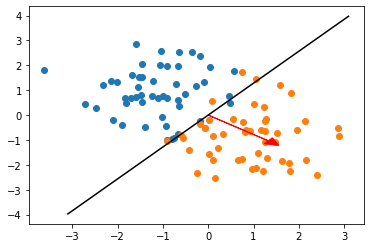

In [22]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

In [23]:
import torch
import torch.nn as nn

In [24]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(n_features, 2, bias=False)
        self.fc2 = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
network = NN()
print(list(network.named_parameters()))

[('fc1.weight', Parameter containing:
tensor([[ 0.0172,  0.5934],
        [ 0.4692, -0.4508]], requires_grad=True)), ('fc2.weight', Parameter containing:
tensor([[-0.5393, -0.4630]], requires_grad=True))]


In [26]:
import torch.optim as optim
from torch.utils.data import DataLoader

In [27]:
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)

In [28]:
data = [[torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).flatten()] for x, y in data]

In [29]:
def train(model, x, y, optimizer, criterion):
    model.zero_grad()
    output = model(x)
    loss =criterion(output,y)
    loss.backward()
    optimizer.step()

    return loss, output

In [30]:
EPOCHS = 200
BATCH_SIZE = 10
data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in data_train:
        x_train, y_train = batch
        loss, predictions = train(network,x_train,y_train, optimizer, criterion)
        epoch_loss+=loss
    print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))

Epoch 1 Loss : 12.299489974975586
Epoch 2 Loss : 11.022195816040039
Epoch 3 Loss : 10.102117538452148
Epoch 4 Loss : 9.42467212677002
Epoch 5 Loss : 8.925541877746582
Epoch 6 Loss : 8.542094230651855
Epoch 7 Loss : 8.2158203125
Epoch 8 Loss : 7.890840530395508
Epoch 9 Loss : 7.554464340209961
Epoch 10 Loss : 7.166629314422607
Epoch 11 Loss : 6.720856666564941
Epoch 12 Loss : 6.201836585998535
Epoch 13 Loss : 5.6486663818359375
Epoch 14 Loss : 5.043362140655518
Epoch 15 Loss : 4.488626003265381
Epoch 16 Loss : 3.9885129928588867
Epoch 17 Loss : 3.5519962310791016
Epoch 18 Loss : 3.164102792739868
Epoch 19 Loss : 2.8879027366638184
Epoch 20 Loss : 2.621995210647583
Epoch 21 Loss : 2.453657627105713
Epoch 22 Loss : 2.3037843704223633
Epoch 23 Loss : 2.1997756958007812
Epoch 24 Loss : 2.129706621170044
Epoch 25 Loss : 2.0563597679138184
Epoch 26 Loss : 2.0108959674835205
Epoch 27 Loss : 1.9749023914337158
Epoch 28 Loss : 1.9534410238265991
Epoch 29 Loss : 1.930202603340149
Epoch 30 Loss : 

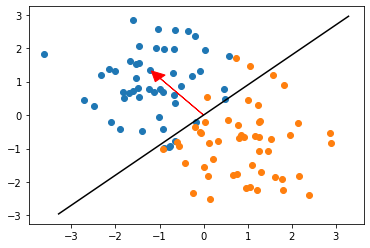

In [31]:
w = list(network.parameters())[1][0].data

plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()